## Supervised Learning
## Project: Finding Donors for *CharityML*

## Getting Started

In this project, I employed several supervised algorithms of my choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data

In [31]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.


In [32]:
#  Total number of records
n_records = len(data)

#  Number of records where individual's income is more than $50,000
n_greater_50k = len([i for i in data['income'] if i == ">50K" ])

#  Number of records where individual's income is at most $50,000
n_at_most_50k = len([i for i in data['income'] if i == "<=50K" ])

#  Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k) / n_records)  * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data


### Transforming Skewed Continuous Features


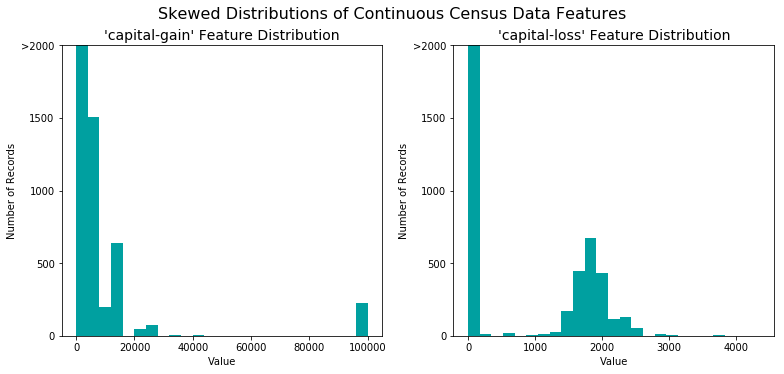

In [33]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

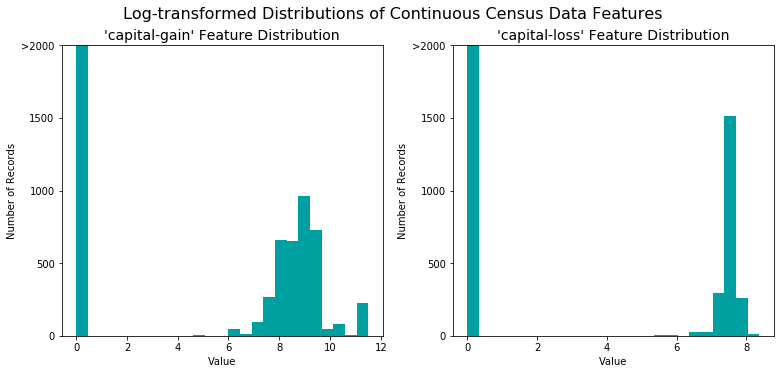

In [34]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features


In [35]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing



In [36]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.map({"<=50K" : 0, ">50K" : 1})

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data

In [37]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 



### Naive Predictor Performace


In [38]:
TP = np.sum(income)
FP = income.count() - TP
TN = 0 
FN = 0
#  Calculate accuracy, precision and recall
accuracy = (TP + TN) / (TP + FP + FN + TN)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

#  Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2)*((precision * recall) / (0.5**2*precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]



**RandomForest:**

- Random Forest is commonly used for Credit Card Fraud Detection.
- It can be used for both classification and regression, and it also prevents overfitting, unlike DecissionTrees.
- It is computationally expensive, and it is not the best option for linear tasks, especially when there are a lot of sparse features.
- It performs well with high-dimensional data and since we have 13 features and 103 features after one-hot encoding, it would be a reasonable choice.

**Support Vector Machines(SVM):**

- SVM is widely used for image classification.
- It is very efficient with high dimentional data. It can prevent overfitting and generalize the data well.
- It doesn't perform well with large data sets, and just like RandomForest, it's computationally expensive.
- It seems to be a good candidate since SVM performs well with binary classification tasks.

**AdaBoost:**

- Ada Boost happens to appear a lot in NLP problems.

- It doesn't have a lot of hyperparameteres to take care of, it doesn't overfit the data.

- It is sensitive to noisy data and outliers.

- It would be a good candidate because it is similar to DecissionTrees, which perform well with binary classification problems, but Decession Trees tend to overfit the data. However, AdaBoost can be a better version of DecisionTrees (boosted version), so it avoids overfitting and works better for the testing data.


**References**

- https://iq.opengenus.org/applications-of-random-forest/
- https://towardsai.net/p/machine-learning/why-choose-random-forest-and-not-decision-trees
- https://www.newgenapps.com/blogs/random-forest-analysis-in-ml-and-when-to-use-it-2/
- https://data-flair.training/blogs/applications-of-svm/
- https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
- https://www.researchgate.net/publication/258400980_An_AdaBoost_Using_a_Weak-Learner_Generating_Several_Weak-Hypotheses_for_Large_Training_Data_of_Natural_Language_Processing
- https://blog.paperspace.com/adaboost-optimizer/

### Implementation - Creating a Training and Predicting Pipeline


In [39]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score 

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 

    
    results = {}
    
    #  Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculate the training time
    results['train_time'] = end - start
        
    #  Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #  Calculate the total prediction time
    results['pred_time'] = end - start
            
    #  Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #  Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #  Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    #  Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5 )
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation


RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


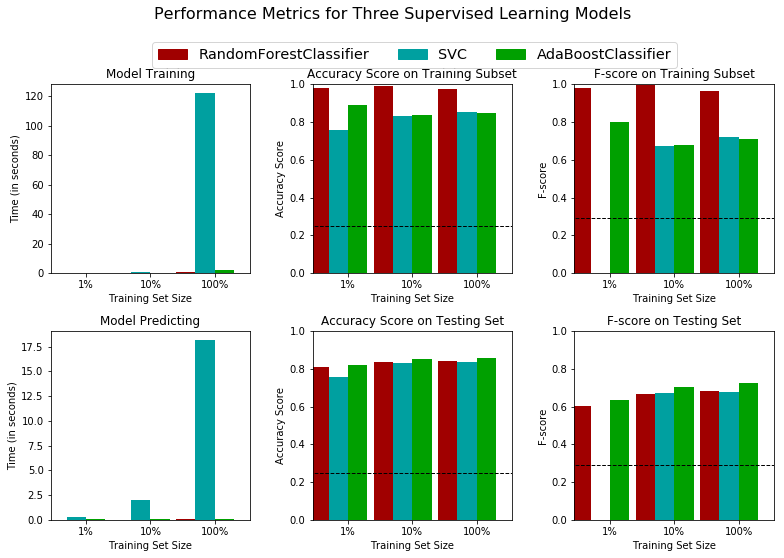

In [40]:
#  Import the three supervised learning models from sklearn
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier 
from sklearn.svm import SVC
#  Initialize the three models
clf_A = RandomForestClassifier(random_state = 42)
clf_B = SVC(random_state = 42)
clf_C = AdaBoostClassifier(random_state = 42)

#  Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


SVM recorded the most expensive training and prediction time among all the algorithms, especially when working on 100% of the data time difference between SVM and the other two algorithms varies much. Therefore, SVM is the slowest algorithm for this case. In the training phase, RandomForest recorded the fastest execution time on 100% of the data, coming after AdaBoost with no big difference in time. In the prediction phase, the RandomForest algorithm was the fastest to execute where AdaBoost came second again. Overall, both the RandomForest and AdaBoost algorithms were fast, but RandomForest was the fastest algorithm to execute. When it comes to accuracy and F-score, all the algorithms recorded quite close results when working on 100% of the data except RandomForest in the training phase It performed amazingly well in the training phase on 100% of the samples, recording above 90% for both accuracy and F-score. On the other hand, AdaBoost and SVM performed decently with around 70% F-score and around 80% accuracy_score for both algorithms. Sadly, RandomForest's performance dropped remarkably in the prediction phase where the Adaboost algorithm came to shine, with the best performance results on 100% of the samples with around 85% accuracy and around 70% F-score, while the RandomForest algorithm came second and SVM came last. 

To conclude, based on the graph above and the analysis, Adaboost showed a relatively fast execution time, performed the best among all the algorithms in the prediction phase, and had a constant performance over all the sample sizes (1%, 10% and 100%). It was also constant in both of the training and prediction phases, thus AdaBoost Algorithm is the most suitable algorithm for this task.


Adaboost combines multiple weak models and produces a single model that works more efficiently on the data. AdaBoost can be implemented in any algorithm, but the most common one is DecisionTrees. DecisionTrees's main problem is that it has this hobby of overfitting and memorising the data more than understanding it, so it performs well in the training phase, but when it comes to testing and seeing new data, it doesn't do very well. Here's where AdaBoost comes to the light by using the DecisionTree algorithm as multiple weak learners and combining all of these weak learners to make a strong one. It's simply an example of how team work could produce better results than working alone!





**References:**

- https://blog.paperspace.com/adaboost-optimizer/
- https://www.mygreatlearning.com/blog/adaboost-algorithm/


### Implementation: Model Tuning


In [41]:
#  Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#  Initialize the classifier
clf = AdaBoostClassifier(random_state = 42)

#  Create the parameters list you wish to tune, using a dictionary if needed.
parameters ={'learning_rate': [0.001, 0.1, 0.2, 0.4, 1, 2],
                  'n_estimators' : [25, 50, 75, 100, 250]
                 }

#  Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta = 0.5)

#  Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)

#  Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-sco

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8653
Final F-score on the testing data: 0.7403




|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.8576           |          0.8653       |
| F-score        |          0.7246         |   0.7403     |



The optimised model performed better than the unoptimized since it recorded a 0.86 accuracy score and a 0.74 F-score. On the other hand, the unoptimized recorded a 0.85 accuracy score and an F-score of 0.72. 

The optimised model performed very well compared to the naive predictor benchmarks, which means that the model was a good choice and also that the parameters were tuned correctly to classify the data.

### Implementation - Extracting Feature Importance


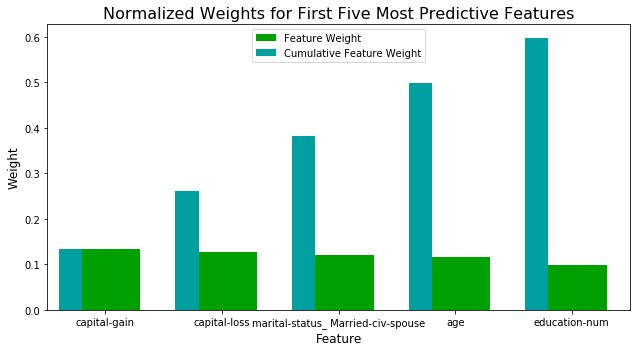

In [42]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = GradientBoostingClassifier(random_state=42).fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Feature Selection


In [43]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8653
F-score on testing data: 0.7403

Final Model trained on reduced data
------
Accuracy on testing data: 0.8561
F-score on testing data: 0.7300




- The model trained on the reduced dataset performed well also, even though it's not as high as the one trained on the full data, since the accuracy only decreased by around 0.01 and the F1-score decreased by around 0.01 as well.

- There are no big differences between the predtions of the two models. On the other hand, the model trained on full data was computationally expensive and the one trained on reduced data was much faster. Thus, it would be very reasonable to consider the model trained on the reduced data.
